## Yield Oracles:  Predicting Soybean Yields in Brazil Using Satellite and Weather Data

This code was written as part of a project to satisfy the [Capstone Course](https://datascience.berkeley.edu/academics/curriculum/synthetic-capstone-course/) requirement of the [UC Berkeley Master of Information and Data Science](https://datascience.berkeley.edu) program.  Our project was completed in April 2016.  For more details and to see our results, please visit our [website](http://amitavadas.github.io/capstone/index.html).  We look forward to your feedback!

For questions and comments about this code, please contact the author, Marguerite Oneto, by email at marguerite.oneto@ischool.berkeley.edu.

# Run A Recurrent Convolutional Neural Network (RNN) Using Theano  
This code is based on an excellent tutorial by Denny Britz giving an introduction to Recurrent Neural Networks.  Please see the links below for more information.  
Reference:  http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-2-implementing-a-language-model-rnn-with-python-numpy-and-theano/   
Reference:  https://github.com/dennybritz/rnn-tutorial-rnnlm   
Data for Unit Test:  https://github.com/maoneto/W210/blob/master/Code/data/reddit-comments-2015-trunc.csv   
Data for Yield Prediction Test: https://github.com/maoneto/W210/blob/master/Code/data/train_tutiempo_10Rings_max.csv 

### Define Theano Utility Functions from utils.py

In [1]:
%%writefile utils.py

import numpy as np

def shuffle_data(p, X, y):
        # shuffle it
        shuffle = np.random.permutation(np.arange(X.shape[0]))
        X, y = X[shuffle], y[shuffle]
        # divide 
        n_train = np.round(X.shape[0]*p)
        return X[:n_train], y[:n_train], X[n_train:], y[n_train:]

def shuffle_data2(X, y, n_train, n_test):
    # shuffle it
    shuffle = np.random.permutation(np.arange(X.shape[0]))
    X, y = X[shuffle], y[shuffle]
    # divide 
    return X[:n_train], y[:n_train], X[n_train:n_train + n_test], y[n_train:n_train + n_test]
    
def softmax(x):
    xt = np.exp(x - np.max(x))
    return xt / np.sum(xt)

def save_model_parameters_theano_ut(outfile, model):
    U, V, W = model.U.get_value(), model.V.get_value(), model.W.get_value()
    np.savez(outfile, U=U, V=V, W=W)
#     print "Saved model parameters to %s." %(outfile)
   
def load_model_parameters_theano_ut(path, model):
    npzfile = np.load(path)
    U, V, W, t_dim = npzfile["U"], npzfile["V"], npzfile["W"]
    model.hidden_dim = U.shape[0]
    model.x_dim = U.shape[1]
    model.U.set_value(U)
    model.V.set_value(V)
    model.W.set_value(W)
    print "Loaded model parameters from %s. hidden_dim=%d word_dim=%d" % (path, U.shape[0], U.shape[1])

def save_model_parameters_theano_yp(outfile, model):
    U, V, W, t_dim = model.U.get_value(), model.V.get_value(), model.W.get_value(), model.t_dim
    np.savez(outfile, U=U, V=V, W=W, t_dim=np.array(t_dim))
#     print "Saved model parameters to %s." %(outfile)
   
def load_model_parameters_theano_yp(path, model):
    npzfile = np.load(path)
    U, V, W, t_dim = npzfile["U"], npzfile["V"], npzfile["W"], npzfile["t_dim"]
    model.hidden_dim = U.shape[0]
    model.x_dim = U.shape[1]
    model.U.set_value(U)
    model.V.set_value(V)
    model.W.set_value(W)
    model.t_dim = t_dim
    print "Loaded model parameters from %s. hidden_dim=%d x_dim=%d, t_dim=%d" % (path, U.shape[0], U.shape[1], t_dim)
    

Overwriting utils.py


##  RNN Unit Test

### Define RNNTheano Class for Unit Test

In [2]:
%%writefile rnn_theano_ut.py

import numpy as np
import theano as theano
import theano.tensor as T
from utils import *
import operator

class RNNTheanoUT:
    
    def __init__(self, word_dim, hidden_dim=100, bptt_truncate=4):
        # Assign instance variables
        self.word_dim = word_dim
        self.hidden_dim = hidden_dim
        self.bptt_truncate = bptt_truncate
        # Randomly initialize the network parameters
        U = np.random.uniform(-np.sqrt(1./word_dim), np.sqrt(1./word_dim), (hidden_dim, word_dim))
        V = np.random.uniform(-np.sqrt(1./hidden_dim), np.sqrt(1./hidden_dim), (word_dim, hidden_dim))
        W = np.random.uniform(-np.sqrt(1./hidden_dim), np.sqrt(1./hidden_dim), (hidden_dim, hidden_dim))
        # Theano: Created shared variables
        self.U = theano.shared(name='U', value=U.astype(theano.config.floatX))
        self.V = theano.shared(name='V', value=V.astype(theano.config.floatX))
        self.W = theano.shared(name='W', value=W.astype(theano.config.floatX))      
        # We store the Theano graph here
        self.theano = {}
        self.__theano_build__()
    
    def __theano_build__(self):
        U, V, W = self.U, self.V, self.W
        x = T.ivector('x')
        y = T.ivector('y')
        def forward_prop_step(x_t, s_t_prev, U, V, W):
            s_t = T.tanh(U[:,x_t] + W.dot(s_t_prev))
            o_t = T.nnet.softmax(V.dot(s_t))
            return [o_t[0], s_t]
        [o,s], updates = theano.scan(
            forward_prop_step,
            sequences=[x],
            outputs_info=[None, dict(initial=T.zeros(self.hidden_dim))],
            non_sequences=[U, V, W],
            truncate_gradient=self.bptt_truncate,
            strict=True)
        
        prediction = T.argmax(o, axis=1)
        o_error = T.sum(T.nnet.categorical_crossentropy(o, y))
        
        # Gradients
        dU = T.grad(o_error, U)
        dV = T.grad(o_error, V)
        dW = T.grad(o_error, W)
        
        # Assign functions
        self.forward_propagation = theano.function([x], o)
        self.predict = theano.function([x], prediction)
        self.ce_error = theano.function([x, y], o_error)
        self.bptt = theano.function([x, y], [dU, dV, dW])
        
        # SGD
        learning_rate = T.scalar('learning_rate')
        self.sgd_step = theano.function([x,y,learning_rate], [], 
                      updates=[(self.U, self.U - learning_rate * dU),
                              (self.V, self.V - learning_rate * dV),
                              (self.W, self.W - learning_rate * dW)])
    
    def calculate_total_loss(self, X, Y):
        return np.sum([self.ce_error(x,y) for x,y in zip(X,Y)])
    
    def calculate_loss(self, X, Y):
        # Divide calculate_loss by the number of words
        num_words = np.sum([len(y) for y in Y])
        return self.calculate_total_loss(X,Y)/float(num_words)  

Overwriting rnn_theano_ut.py


### Train Theano RNN for Unit Test

In [3]:
#! /usr/bin/env python
%reload_ext autoreload
%autoreload 2

import csv
import itertools
import operator
import numpy as np
import nltk
import sys
import os
import time
from datetime import datetime
from utils import *
from rnn_theano_ut import RNNTheanoUT

_VOCABULARY_SIZE = int(os.environ.get('VOCABULARY_SIZE', '400'))
_HIDDEN_DIM = int(os.environ.get('HIDDEN_DIM', '100'))
_LEARNING_RATE = float(os.environ.get('LEARNING_RATE', '0.005'))
_NEPOCH = int(os.environ.get('NEPOCH', '2'))
_MODEL_FILE = os.environ.get('MODEL_FILE')

def train_with_sgd(model, X_train, y_train, X_test, learning_rate=0.005, nepoch=1, evaluate_loss_after=1):
    # Create file to save test dataset predictions
    filename = 'save_' + datetime.now().strftime("%Y%m%d%H%M%S") + '.txt'
    print 'epoch#: %d, training#: %s, file: %s' %(nepoch, y_train.shape[0], filename)        
    # We keep track of the losses so we can plot them later
    min_loss = 100000
    losses = []
    num_examples_seen = 0
    for epoch in range(nepoch):
        # Adjust the learning rate if loss increases
        if (len(losses) > 1 and losses[-1][1] > losses[-2][1]):
            learning_rate = learning_rate * 0.5  
            print "Setting learning rate to %f" % learning_rate
        # Train the model
        epoch_start = time.time()
        for i in range(len(y_train)):
            # One SGD step
            model.sgd_step(X_train[i], y_train[i], learning_rate)
            num_examples_seen += 1
        epoch_time = time.time() - epoch_start        
        # Calculate loss
        loss = model.calculate_loss(X_train, y_train)
        losses.append((num_examples_seen, loss))
        # If loss is a new minimum, then make predictions on the test dataset and save model parameters
        isSaved = ''
        if loss < min_loss:
            min_loss = loss
            X_test_predictions = []
            for i in range(len(X_test_predictions)):
                X_test_predictions.append(model.predict(X_test[i]))
            np.savetxt(filename, X_test_predictions)
            isSaved = '(saved)'
            # ADDED! Saving model parameters
            save_model_parameters_theano_ut("./data/rnn-theano-%d-%d.npz" % (model.hidden_dim, model.word_dim), model)
        print 'Epoch %d) Loss = %.4f, ExamplesSeen = %d, trainTime = %.2f min, endTime = %s %s' %(epoch+1, loss, num_examples_seen, epoch_time/60, time.strftime("%I:%M:%S"), isSaved)
        
    return X_test_predictions, losses
        
        
vocabulary_size = _VOCABULARY_SIZE
unknown_token = "UNKNOWN_TOKEN"
sentence_start_token = "SENTENCE_START"
sentence_end_token = "SENTENCE_END"

# Read the data and append SENTENCE_START and SENTENCE_END tokens
print "Reading CSV file..."
with open('data/reddit-comments-2015-trunc.csv', 'rb') as f:
    reader = csv.reader(f, skipinitialspace=True)
    reader.next()
    # Split full comments into sentences
    sentences = itertools.chain(*[nltk.sent_tokenize(x[0].decode('utf-8').lower()) for x in reader])
    # Append SENTENCE_START and SENTENCE_END
    sentences = ["%s %s %s" % (sentence_start_token, x, sentence_end_token) for x in sentences]
print "Parsed %d sentences." % (len(sentences))
    
# Tokenize the sentences into words
tokenized_sentences = [nltk.word_tokenize(sent) for sent in sentences]

# Count the word frequencies
word_freq = nltk.FreqDist(itertools.chain(*tokenized_sentences))
print "Found %d unique words tokens." % len(word_freq.items())

# Get the most common words and build index_to_word and word_to_index vectors
vocab = word_freq.most_common(vocabulary_size-1)
index_to_word = [x[0] for x in vocab]
index_to_word.append(unknown_token)
word_to_index = dict([(w,i) for i,w in enumerate(index_to_word)])

print "Using vocabulary size %d." % vocabulary_size
print "The least frequent word in our vocabulary is '%s' and appeared %d times." % (vocab[-1][0], vocab[-1][1])

# Replace all words not in our vocabulary with the unknown token
for i, sent in enumerate(tokenized_sentences):
    tokenized_sentences[i] = [w if w in word_to_index else unknown_token for w in sent]

# Create the training data
X_train = np.asarray([[word_to_index[w] for w in sent[:-1]] for sent in tokenized_sentences])
y_train = np.asarray([[word_to_index[w] for w in sent[1:]] for sent in tokenized_sentences])
X_test = X_train[0:10]

model = RNNTheanoUT(vocabulary_size, hidden_dim=_HIDDEN_DIM)
t1 = time.time()
model.sgd_step(X_train[10], y_train[10], _LEARNING_RATE)
t2 = time.time()
print "SGD Step time: %f milliseconds" % ((t2 - t1) * 1000.)

if _MODEL_FILE != None:
    load_model_parameters_theano_ut(_MODEL_FILE, model)

y_hat, losses = train_with_sgd(model, X_train, y_train, X_test, nepoch=_NEPOCH, learning_rate=_LEARNING_RATE)

Reading CSV file...
Parsed 101 sentences.
Found 689 unique words tokens.
Using vocabulary size 400.
The least frequent word in our vocabulary is 'way' and appeared 1 times.
SGD Step time: 3.376007 milliseconds
epoch#: 2, training#: 101, file: save_20160427135528.txt
Epoch 1) Loss = 5.9811, ExamplesSeen = 101, trainTime = 0.00 min, endTime = 01:55:28 (saved)
Epoch 2) Loss = 5.9665, ExamplesSeen = 202, trainTime = 0.00 min, endTime = 01:55:28 (saved)


/Users/SendIt/anaconda/lib/python2.7/site-packages/theano/scan_module/scan.py:1017: Warning: In the strict mode, all neccessary shared variables must be passed as a part of non_sequences
  'must be passed as a part of non_sequences', Warning)


## RNN for Yield Prediction    
We made several changes to the code above to improve performance and to adapt it to our yield prediction problem.   
1. The code above solves a classification problem, whereas we needed to predict the value of a continuous variable.  In order to do this, we made changes to the last calculation in the forward propagation step (Line 57 in rnn_theano_yp.py), to the objective function (Line 100 in rnn_theano_yp.py) and to the prediction calculation (Line 99 in rnn_theano_yp.py).   
2. To control for overfitting, we added dropout to the training (Lines 48-56 in rnn_theano_yp.py).   
3. To speed up training, we used rmsprop, which allows for an adaptive learning rate for each parameter.  We used the method and code from here:  http://www.wildml.com/2015/10/recurrent-neural-network-tutorial-part-4-implementing-a-grulstm-rnn-with-python-and-theano/  

### Create Training and Test Datasets for Yield Prediction

In [4]:
import math
import csv
import numpy as np
import pandas as pd
import ast
from sklearn.cross_validation import train_test_split

X = []
Y = []

num_images = 13
with open('train_tutiempo_10Rings_max.csv', 'r') as csvfile:
    datareader = csv.reader(csvfile, delimiter=',')
    for row in datareader:
        label = row.pop()  # pop the last element in the list which is the label (yield_calc)
        if float(label) != 0.0: # all of this is done to get x into the right dimensions for SGD
            line = []
            for i in range(num_images):
                value = []
                for j in range(len(ast.literal_eval(row[i]))):
                    value.append([ast.literal_eval(row[i])[j]])
                line.append(value)
            X.append(line)
            Y.append(len(X[0])*[label]) # output/prediction at each t, o_t, is the yield
X = np.array(X).astype(np.float)
Y = np.array(Y).astype(np.float)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=22)

log_Y_train = np.log(Y_train)
log_Y_test = np.log(Y_test)

print "X_train and X_test Shape:"
print X_train.shape, X_test.shape

print "Y_train, Y_test, log_Y_train, log_Y_test Shape:"
print Y_train.shape, Y_test.shape, log_Y_train.shape, log_Y_test.shape


X_train and X_test Shape:
(958, 13, 23, 1) (240, 13, 23, 1)
Y_train, Y_test, log_Y_train, log_Y_test Shape:
(958, 13) (240, 13) (958, 13) (240, 13)


### Define RNNTheano Class for Yield Prediction

In [5]:
%%writefile rnn_theano_yp.py

import numpy as np
import theano as theano
import theano.tensor as T
from theano import printing
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
from utils import *
import operator

theano.exception_verbosity='high'
theano.mode='FAST_COMPILE'
theano.allow_gc=False
theano.optimizer='fast_compile'
theano.config.compute_test_value = 'off'

class RNNTheanoYP:
    
    def __init__(self, x_dim=1, t_dim=1, hidden_dim=100, bptt_truncate=4):
        # Assign instance variables
        self.x_dim = x_dim
        self.t_dim = t_dim
        self.hidden_dim = hidden_dim
        self.bptt_truncate = bptt_truncate
        # Randomly initialize the network parameters
        U = np.random.uniform(-np.sqrt(1./x_dim), np.sqrt(1./x_dim), (hidden_dim, x_dim))
        V = np.random.uniform(-np.sqrt(1./hidden_dim), np.sqrt(1./hidden_dim), (1, hidden_dim))
        W = np.random.uniform(-np.sqrt(1./hidden_dim), np.sqrt(1./hidden_dim), (hidden_dim, hidden_dim))
        # Theano: Create shared variables
        self.U = theano.shared(name='U', value=U.astype(theano.config.floatX))
        self.V = theano.shared(name='V', value=V.astype(theano.config.floatX))
        self.W = theano.shared(name='W', value=W.astype(theano.config.floatX))   
        # SGD / rmsprop: Initialize parameters
        self.mU = theano.shared(name='mU', value=np.zeros(U.shape).astype(theano.config.floatX))
        self.mV = theano.shared(name='mV', value=np.zeros(V.shape).astype(theano.config.floatX))
        self.mW = theano.shared(name='mW', value=np.zeros(W.shape).astype(theano.config.floatX))
        # We store the Theano graph here
        self.theano = {}
        self.__theano_build__()

    
    def __theano_build__(self):
        U, V, W = self.U, self.V, self.W
        x = T.tensor3('x')
        y = T.vector('y')
        p = T.scalar('p')
        
        def dropout(X, p, srng_t_prev):
            if T.lt(0.0, p):
                X *= 1.0*srng_t_prev
                X /= 1.0 - p
            srng_t = 1.0*RandomStreams().binomial((self.hidden_dim, 1), p=1 - p)
            return X, srng_t
        
        def forward_prop_step(x_t, s_t_prev, srng_t_prev, U, V, W, p):
            s_t, srng_t = dropout(T.nnet.softplus(T.dot(U, x_t) + T.dot(W, s_t_prev)), p, srng_t_prev)  # T.tanh, T.nnet.relu
            o_t = T.dot(V, s_t)
#             for debugging ...
#             print U.shape.eval()
#             print V.shape.eval()
#             print W.shape.eval()
#             print (T.dot(U, x_t)).eval({x_t: [[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1]]})               
#             print (T.dot(W, s_t_prev)).eval({s_t_prev: np.zeros((self.hidden_dim, 1))})
#             print (T.dot(U, x_t) + T.dot(W, s_t_prev)).eval({x_t: [[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1]], 
#                             s_t_prev: np.zeros((self.hidden_dim, 1))})
#             print (T.nnet.softplus(T.dot(U, x_t) + T.dot(W, s_t_prev))).eval({x_t: [[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1]], 
#                             s_t_prev: np.zeros((self.hidden_dim, 1))})
#             print srng_t.eval()
#             print s_t.eval({x_t: [[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1]], 
#                             s_t_prev: np.zeros((self.hidden_dim, 1)),
#                             srng_t_prev: np.ones((self.hidden_dim, 1))})
#             print o_t.eval({x_t: [[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1],[1]], 
#                             s_t_prev: np.zeros((self.hidden_dim, 1)),
#                            srng_t_prev: np.ones((self.hidden_dim, 1))})
            return [o_t, s_t, srng_t]


        [o,s,srng], updates = theano.scan(
            fn=forward_prop_step,
            sequences=[x],
            outputs_info=[None, 
                          dict(initial=T.unbroadcast(T.zeros_like(T.reshape(V,[self.hidden_dim, 1], ndim=2)), 1)),  #dtype=theano.config.floatX 
                          dict(initial=T.unbroadcast(T.ones_like(T.reshape(V,[self.hidden_dim, 1], ndim=2)), 1))],  #dtype=theano.config.floatX 
            non_sequences=[U, V, W, 0.5],
            truncate_gradient=self.bptt_truncate,
            strict=True)
        
        [o_predict,s_predict,srng_predict], updates = theano.scan(
            fn=forward_prop_step,
            sequences=[x],
            outputs_info=[None, 
                          dict(initial=T.unbroadcast(T.zeros_like(T.reshape(V,[self.hidden_dim, 1], ndim=2)), 1)),  #dtype=theano.config.floatX 
                          dict(initial=T.unbroadcast(T.ones_like(T.reshape(V,[self.hidden_dim, 1], ndim=2)), 1))],  #dtype=theano.config.floatX 
            non_sequences=[U, V, W, 0.0],  # predictions do not use dropout, so set p = 0.0
            truncate_gradient=self.bptt_truncate,
            strict=True)

        
        prediction = o_predict
        o_error = T.sum(T.sqr(o - T.reshape(y, [self.t_dim,1,1], ndim=3)))
        predict_error = T.sum(T.sqr(o_predict - T.reshape(y, [self.t_dim,1,1], ndim=3)))

        # Gradients
        dU = T.grad(o_error, U)
        dV = T.grad(o_error, V)
        dW = T.grad(o_error, W)
        
        # Assign functions
        self.forward_propagation = theano.function([x], o)
        self.predict = theano.function([x], prediction)
        self.sse_error = theano.function([x, y], o_error)
        self.predict_error = theano.function([x, y], predict_error)
        self.bptt = theano.function([x, y], [dU, dV, dW])
        
        # SGD
        learning_rate = T.scalar('learning_rate')
        decay = T.scalar('decay')
        
        # rmsprop cache updates
        mU = decay * self.mU + (1 - decay) * dU ** 2
        mW = decay * self.mW + (1 - decay) * dW ** 2
        mV = decay * self.mV + (1 - decay) * dV ** 2
        
        self.sgd_step = theano.function(
            [x,y,learning_rate,theano.Param(decay, default=0.9)], 
            [], 
            updates=[(U, U - learning_rate * dU / T.sqrt(mU + 1e-6)),
                     (W, W - learning_rate * dW / T.sqrt(mW + 1e-6)),
                     (V, V - learning_rate * dV / T.sqrt(mV + 1e-6)),
                     (self.mU, mU),
                     (self.mW, mW),
                     (self.mV, mV),
                    ])


    def calculate_total_loss(self, X, Y, predict=False):
        if predict:
            return np.sum([self.predict_error(x,y) for x,y in zip(X,Y)])            
        else:
            return np.sum([self.sse_error(x,y) for x,y in zip(X,Y)])
    
    def calculate_loss(self, X, Y, predict=False):
        # Divide calculate_loss by the number of examples
        num_examples = np.sum([len(y) for y in Y])
        if predict:
            return self.calculate_total_loss(X,Y,True)/float(num_examples)   
        else:
            return self.calculate_total_loss(X,Y,False)/float(num_examples)   



Overwriting rnn_theano_yp.py


### Train Theano RNN for Yield Prediction

In [6]:
#! /usr/bin/env python
# Make sure the latest code updates are loaded
%reload_ext autoreload
%autoreload 2

import csv
import itertools
import operator
import numpy as np
import sys
import os
import time
from datetime import datetime
from utils import *
from rnn_theano_yp import RNNTheanoYP

_X_DIM = int(os.environ.get('X_DIM', '23')) # number of features in the x_t vector
_TIME_DIM = int(os.environ.get('TIME_DIM', '13')) # number of time periods
_HIDDEN_DIM = int(os.environ.get('HIDDEN_DIM', '100'))
_LEARNING_RATE = float(os.environ.get('LEARNING_RATE', '0.001'))
_DECAY_RATE = float(os.environ.get('DECAY_RATE', '0.90'))
_NEPOCH = int(os.environ.get('NEPOCH', '10'))
_MODEL_FILE = os.environ.get('MODEL_FILE')

def train_with_sgd(model, X_train, y_train, X_test, y_test, learning_rate=0.005, decay_rate=0.90, nepoch=1):
    # Set start of training time
    start_time = time.time()
    # Set model time
    modeltime = datetime.now().strftime("%Y%m%d%H%M%S")
    print 'Epochs: %d, TrainingSamples: %s, ModelTime: %s' %(nepoch, y_train.shape[0], modeltime)        
    # Set epoch variables
    min_loss = 100000
    train_losses = []
    val_losses = []
    num_examples_seen = 0
    # divide the data
    train_data, train_labels, val_data, val_labels = shuffle_data(0.9, X_train, y_train)  # Use this for full sample training  
#     train_data, train_labels, val_data, val_labels = shuffle_data2(X_train, y_train, 200000, 20000)  # Use this for testing and debugging  
    for epoch in range(nepoch):
#         # Adjust the learning rate if loss increases
#         if (len(train_losses) > 1 and train_losses[-1][1] >= train_losses[-2][1]):
#             learning_rate = learning_rate * 0.80  
#             print "Setting learning rate to %f" % learning_rate
        # Shuffle the training data
        shuffle = np.random.permutation(np.arange(train_data.shape[0]))
        train_data, train_labels = train_data[shuffle], train_labels[shuffle]
        # Train the model
        epoch_start = time.time()
        # for each training example ...
        for i in range(len(train_data)):
            # One SGD step
            model.sgd_step(train_data[i], train_labels[i], learning_rate, decay_rate)
            num_examples_seen += 1
        epoch_time = time.time() - epoch_start        
        # Calculate training loss
        train_loss = model.calculate_loss(train_data, train_labels, predict=False)
        train_losses.append((num_examples_seen, train_loss))
        # Calculate validation loss, R-squared, and RMSE
        val_loss = model.calculate_loss(val_data, val_labels, predict=True)
        val_losses.append((num_examples_seen, val_loss))
        val_predictions = []
        for i in range(len(val_data)):
            val_predictions.append(model.predict(val_data[i]))
        val_predictions = np.reshape(val_predictions, (len(val_predictions), len(val_predictions[0])))
        val_R_squared = 1 - np.sum(np.square(val_predictions - val_labels))/np.sum(np.square(val_labels - np.mean(val_labels)))
        val_rmse = np.sqrt(np.mean(np.square(val_predictions - val_labels)))
        # If validation loss is a new minimum, save predictions and model   
        is_saved = ''
        if val_loss < min_loss:
            min_loss = val_loss
            # Make and save predictions
            X_test_predictions = []
            for i in range(len(X_test)):
                label = float(y_test[i][0])
                X_test_predictions.append(np.append(model.predict(X_test[i]).reshape(len(X_test[i])), label))
            predictions_and_labels = np.asarray(X_test_predictions)
            filename = "./predictions/RNNs/pred-%s.txt" %(modeltime)
            np.savetxt(filename, predictions_and_labels, fmt='%.18f', delimiter=',',)
            # Save model parameters
            filename = "./models/RNNs/RNN-%s.npz" % (modeltime)
            save_model_parameters_theano_yp(filename, model)
            is_saved = 'saved'
        # Print epoch stats
        print '%d) ExamplesSeen=%d, TrainLoss=%.4f, ValLoss=%.4f, ValRMSE=%.4f, TrainTime=%.2fmin, EndTime=%s %s' %(epoch+1, num_examples_seen, train_loss, val_loss, val_rmse, epoch_time/60, time.strftime("%I:%M:%S"), is_saved)
    print 'Finished.  Total train time = %.2f hours' %((time.time() - start_time)/3600)   
    
    return train_losses, val_losses
        
# Start Time
print 'Start Time: %s' %(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

# Build the model
model = RNNTheanoYP(x_dim=_X_DIM, t_dim=_TIME_DIM, hidden_dim=_HIDDEN_DIM)

# Measure and Print SGD step time
t1 = time.time()
model.sgd_step(X_train[10], Y_train[10], _LEARNING_RATE, _DECAY_RATE)
t2 = time.time()
print "SGD Step time: %f milliseconds" % ((t2 - t1) * 1000.)

# if _MODEL_FILE != None:
#     load_model_parameters_theano_yp(_MODEL_FILE, model)

# Train the model
train_losses, val_losses = train_with_sgd(model, X_train, log_Y_train, X_test, Y_test, learning_rate=_LEARNING_RATE, decay_rate = _DECAY_RATE, nepoch=_NEPOCH)

# End Time
print 'End Time: %s' %(datetime.now().strftime("%Y-%m-%d %H:%M:%S")) 


Start Time: 2016-04-27 13:55:58
SGD Step time: 1.466036 milliseconds
Epochs: 10, TrainingSamples: 958, ModelTime: 20160427135615
1) ExamplesSeen=862, TrainLoss=0.3416, ValLoss=0.4367, ValRMSE=0.6609, TrainTime=0.01min, EndTime=01:56:16 saved
2) ExamplesSeen=1724, TrainLoss=0.3382, ValLoss=0.3971, ValRMSE=0.6302, TrainTime=0.01min, EndTime=01:56:17 saved
3) ExamplesSeen=2586, TrainLoss=0.4439, ValLoss=0.4256, ValRMSE=0.6524, TrainTime=0.01min, EndTime=01:56:18 
4) ExamplesSeen=3448, TrainLoss=0.3898, ValLoss=0.4904, ValRMSE=0.7003, TrainTime=0.01min, EndTime=01:56:19 
5) ExamplesSeen=4310, TrainLoss=0.4231, ValLoss=0.4389, ValRMSE=0.6625, TrainTime=0.01min, EndTime=01:56:20 
6) ExamplesSeen=5172, TrainLoss=0.3626, ValLoss=0.4052, ValRMSE=0.6365, TrainTime=0.01min, EndTime=01:56:21 
7) ExamplesSeen=6034, TrainLoss=0.4346, ValLoss=0.4156, ValRMSE=0.6447, TrainTime=0.01min, EndTime=01:56:23 
8) ExamplesSeen=6896, TrainLoss=0.4199, ValLoss=0.4557, ValRMSE=0.6750, TrainTime=0.01min, EndTime=

### Baseline Model:  The Mean

In [7]:
Y_train_1d = Y_train[:,0]
y_hat = len(Y_test)*[np.mean(Y_train_1d)]
y_test = Y_test[:,0]

y_hat = np.array(y_hat).astype(np.float)
y_test = np.array(y_test).astype(np.float)
y_bar = np.mean(y_test)

R_squared = 1 - np.sum(np.square(y_hat - y_test))/np.sum(np.square(y_test - y_bar))
mae = np.mean(np.abs(y_hat - y_test))
rmse = np.sqrt(np.mean(np.square(y_hat - y_test)))
mape = np.mean(abs(np.divide((y_hat - y_test), y_test)))

print 'R-Squared: %.4f, MAE: %.4f, RMSE: %.4f, MAPE: %.2f%s' %(R_squared, mae, rmse, mape*100, '%')  

R-Squared: -0.0045, MAE: 0.9071, RMSE: 1.1617, MAPE: 71.53%


### Calculate Performance Stats on Holdout Sample
These are the predictions on a holdout sample (X_test above) using the model with the lowest validation loss.    
- t-0 = prediction at harvest time   
- t-6 = prediction three months out from harvest   
- t-12 = prediction six months out from harvest   

In [8]:
import csv
import numpy as np

y_hat = []
Y_test = []
with open('./predictions/RNNs/pred-20160427135615.txt', 'r') as csvfile:
    datareader = csv.reader(csvfile, delimiter=',')
    for row in datareader:
        label = row.pop()
        y_hat.append(row)
        Y_test.append(label)

# Results keeping predictions as logs of yield
y_hat = np.array(y_hat).astype(np.float)
Y_test = np.array(Y_test).astype(np.float)
y_test = np.log(Y_test)
y_bar = np.mean(y_test)

print 'Log-Transformed Yield Results:'
for j in range(len(y_hat[0])):
    y_hat_last = y_hat[:, j]
    R_squared = 1 - np.sum(np.square(y_hat_last - y_test))/np.sum(np.square(y_test - y_bar))
    mae = np.mean(np.abs(y_hat_last - y_test))
    rmse = np.sqrt(np.mean(np.square(y_hat_last - y_test)))
    count = 0
    sums = 0
    for i in range(len(y_test)):
        if y_test[i] != 0: 
            error = np.divide(abs(y_hat_last[i] - y_test[i]), abs(y_test[i]))
            count += 1
            sums += error
    mean_abs_pct_error = sums/count
    print 't-%d) R-Squared: %.4f, MAE: %.4f, RMSE: %.4f, MAPE: %.2f%s' %(len(y_hat[0])-1-j, R_squared, mae, rmse, mean_abs_pct_error*100, '%')
    
    
# Results transforming predictions and yields back to original units
y_hat = np.array(y_hat).astype(np.float)
y_test = np.array(Y_test).astype(np.float)
y_bar = np.mean(y_test)

y_hat_exp = np.exp(y_hat)

print '\nValues Transformed Back to Original Units Results:'
for j in range(len(y_hat_exp[0])):
    y_hat_last = y_hat_exp[:, j]
    R_squared = 1 - np.sum(np.square(y_hat_last - y_test))/np.sum(np.square(y_test - y_bar))
    mae = np.mean(np.abs(y_hat_last - y_test))
    rmse = np.sqrt(np.mean(np.square(y_hat_last - y_test)))
    count = 0
    sums = 0
    for i in range(len(y_test)):
        if y_test[i] != 0: 
            error = np.divide(abs(y_hat_last[i] - y_test[i]), abs(y_test[i]))
            count += 1
            sums += error
    mean_abs_pct_error = sums/count
    print 't-%d) R-Squared: %.4f, MAE: %.4f, RMSE: %.4f, MAPE: %.2f%s' %(len(y_hat_exp[0])-1-j, R_squared, mae, rmse, mean_abs_pct_error*100, '%')


Log-Transformed Yield Results:
t-12) R-Squared: -0.0801, MAE: 0.4295, RMSE: 0.6079, MAPE: 98.81%
t-11) R-Squared: -0.0779, MAE: 0.4693, RMSE: 0.6073, MAPE: 85.27%
t-10) R-Squared: -0.0157, MAE: 0.4427, RMSE: 0.5895, MAPE: 85.29%
t-9) R-Squared: 0.0329, MAE: 0.4245, RMSE: 0.5752, MAPE: 84.71%
t-8) R-Squared: 0.0701, MAE: 0.4122, RMSE: 0.5640, MAPE: 85.24%
t-7) R-Squared: 0.0769, MAE: 0.4054, RMSE: 0.5620, MAPE: 87.77%
t-6) R-Squared: 0.1175, MAE: 0.3942, RMSE: 0.5495, MAPE: 88.15%
t-5) R-Squared: 0.1699, MAE: 0.3772, RMSE: 0.5329, MAPE: 83.15%
t-4) R-Squared: 0.1704, MAE: 0.3733, RMSE: 0.5328, MAPE: 79.52%
t-3) R-Squared: 0.1665, MAE: 0.3609, RMSE: 0.5340, MAPE: 81.92%
t-2) R-Squared: 0.1626, MAE: 0.3645, RMSE: 0.5353, MAPE: 81.30%
t-1) R-Squared: 0.1240, MAE: 0.3734, RMSE: 0.5475, MAPE: 82.81%
t-0) R-Squared: 0.1188, MAE: 0.3743, RMSE: 0.5491, MAPE: 84.08%

Values Transformed Back to Original Units Results:
t-12) R-Squared: -0.2632, MAE: 1.0485, RMSE: 1.3028, MAPE: 68.35%
t-11) R-Squar

### Graph Losses

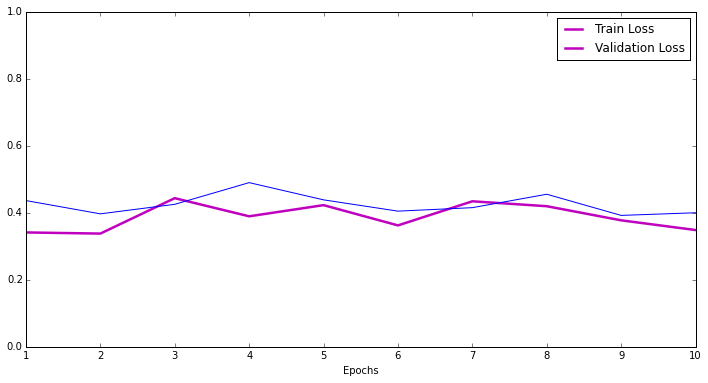

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses, epochs, y_min, y_max):
    x1 = range(1, epochs+1, 1)
    y1 = train_losses
    x2 = range(1, epochs+1, 1)
    y2 = val_losses
    plt.figure(figsize=(12, 6))
    plt.axis((1, epochs, y_min, y_max))
    plt.plot(x1, y1, "-m", linewidth=2.5, label='Train Loss') 
    plt.plot(x2, y2, "-b", linewidth=1.0, label='Validation Loss')
    plt.legend(['Train Loss', 'Validation Loss'])
    plt.xlabel('Epochs')
    plt.show()

plot_losses(train_losses, val_losses, epochs=10, y_min=0.0, y_max=1.0)

### Code for Reloading the Saved Best Model

In [10]:
reloaded_model = load_model_parameters_theano_yp("./models/RNNs/RNN-20160427131504.npz", model)

Loaded model parameters from ./models/RNNs/RNN-20160427131504.npz. hidden_dim=100 x_dim=23, t_dim=13
